<a href="https://colab.research.google.com/github/Sopralapanca/ComputationalHealthLab/blob/master/%5BCHL%5DClinicalDataEncoder_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHL - Group 5 - Clinical Data Encoder

1. Data prep: Replace missng values with numeric numbers.
2. CL1: Classify prediction of death 7 years downstream.
3. ENC: Train an autoencoder with a transformer architecture.
4. CL2: Classify prediciton of death 7 years downstream from the encoded representation.
5. RES: Show results

## TODO

1. aggiungere le loss f1 test , auroc, binary confusion matrix
2. Regolarizzazione
3. plot attention matrices
4. autoenc transformer unsupervised masked word prediction (augmentation)

## Helper functions

In [ ]:
# number of CVD Death that are also Cardiac cause of death (intersection)
#def test_intersection(df,f1,f2):
#  return {
#      "intersection" : len(df[df[f1].dropna().astype(int) & df[f2].dropna().astype(int)]),
#      f"{f1}_only" : len(df[df[f1].dropna().astype(int) & ~df[f2].dropna().astype(int)]),
#      f"{f2}_only"  : len(~df[df[f1].dropna().astype(int) & df[f2].dropna().astype(int)]),
#  }

In [1]:
%%capture
!pip3 install torch torchvision torchaudio lightning --no-cache-dir 

In [2]:
import torch
print(torch.__version__)
import sys
print(sys.version)

2.0.0+cu118
3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [3]:
%%capture
%pip install torchmetrics

In [4]:
%%capture
!pip install bertviz

## 1. Data prep

### 1.1 Import and understanding

* dates as days since 1998
* categories to sequential numbering [nans are not converted]
* minmax scaler

this process will produce the following variables:

* df_raw [original]
* df [normalized]
* num_encodings {variable:{class_name:number,...},...}
* norm_params [min, delta, alpha]

In [5]:
%%capture
import pandas as pd
import numpy as np
from pprint import pprint
import sklearn as sk

seed = 11

# clone the repository in order to download the dataset
!git clone https://github.com/Sopralapanca/ComputationalHealthLab.git

data_path = "/content/ComputationalHealthLab/datasets/TiroideCardio_dataset.csv"
# we consider the dates as days (int) from 1998
def date_parser(date): 
    return (pd.to_datetime(date, format='%d/%m/%Y')-pd.to_datetime('01/01/1997', format='%d/%m/%Y')).days

date_columns = ["Data prelievo (1)",	"Data of death",	"CABG ",	"Non Fatal AMI (Follow-Up)",	"PCI", "Ictus"]
df_raw = pd.read_csv(data_path,parse_dates=date_columns,date_parser=date_parser)
df_raw["Follow Up Data"] = df_raw["Follow Up Data"].apply(date_parser) # this needs to be caster aftewrwards to avoid errors

In [6]:
# removing \n  and rename the columns
columns = df_raw.columns
new_cols = columns.str.replace('\n', '_', regex=False).str.replace('(1)', '', regex=False).str.replace(' ', '', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.replace('=', '', regex=False).str.replace('-', '', regex=False)

col_dict = {}
for old, new in zip(columns, new_cols):
    col_dict[old] = new

df_raw = df_raw.rename(columns=col_dict)

In [7]:
df_raw.drop(columns=['N.patients'],inplace=True) #N.patients is a column of IDs so it is irrelevant for the classification task

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5820 entries, 0 to 5819
Data columns (total 93 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Dataprelievo                            5819 non-null   float64
 1   Age                                     5820 non-null   int64  
 2   GenderMale1                             5820 non-null   int64  
 3   Angina                                  5820 non-null   int64  
 4   PreviousCABG                            5820 non-null   int64  
 5   PreviousPCI                             5820 non-null   int64  
 6   Previous_MyocardialInfarction           5820 non-null   int64  
 7   Acute_MyocardialInfarction              5820 non-null   int64  
 8   Angiography                             5820 non-null   int64  
 9   Vessels                                 3562 non-null   float64
 10  CAD                                     5820 non-null   int6

In [9]:
#function to discretize the variables 
#input: the dataset and the list of variables' names to discretize 
def discretize_data(df, variables):
    dataset = df.copy(deep=True)
    encoding = {}
    for variable in variables: 
        #get the unique variable's values 
        var = dataset[variable].dropna().unique()
         
        #generate a mapping from the variable's values to the number representation   
        mapping = dict(zip(var, range(0, len(var) + 1))) 
 
        #add a new colum with the number representation of the variable 
        dataset[variable] = dataset[variable].map(mapping)
        encoding[variable]=mapping
    return dataset,encoding

In [10]:
def undiscretize_data(df, encoding):
   """to be defined"""
   return np.nan

In [11]:
df_raw['Collectedby'] = df_raw['Collectedby'].replace("Phisician","Physician") #Collectedby has two class that can be merged since Phisician is a typo

In [12]:
nonbinray_categorical = ['PatologiaTIROIDE','Causeofdeath','Collectedby'] # These three columns are the ones with categorical feature that can be discretized
df,num_encodings = discretize_data(df_raw,nonbinray_categorical)

In [13]:
df["PatologiaTIROIDE"].dropna().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31.])

In [14]:
df[['PatologiaTIROIDE','Causeofdeath','Collectedby']]

,PatologiaTIROIDE,Causeofdeath,Collectedby
0,0.0,0.0,0.0
1,NaN,0.0,0.0
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,0.0,0.0
...,...,...,...
5815,NaN,NaN,NaN
5816,NaN,4.0,0.0
5817,NaN,12.0,0.0
5818,NaN,NaN,NaN


In [15]:
# checking number of unique values for each feature
for k in df.keys():
  l = len(df[k].value_counts())
  print(k,'->',l)

Dataprelievo -> 2768
Age -> 84
GenderMale1 -> 2
Angina -> 2
PreviousCABG -> 2
PreviousPCI -> 2
Previous_MyocardialInfarction -> 2
Acute_MyocardialInfarction -> 2
Angiography -> 2
Vessels -> 6
CAD -> 2
Smoke_Historyofsmoke -> 2
Diabetes_Historyofdiabetes -> 2
Hypertension_Historyofhypertension -> 2
Dyslipidemia_Hystoryofdyslipidemia -> 2
FamilyhistoryofCAD -> 2
Obesity_Historyofobesity -> 2
Documentedresting_orexertionalischemia -> 2
PostischemicDilated_Cardiomyopathy -> 2
PrimaryDilated_Cardiomyopathy -> 2
AtrialFibrillation -> 2
Paroxysmalatrialfibrillation -> 2
BBlockers -> 2
Amiodarone -> 2
Calciumchannelblockers -> 2
Diuretics -> 2
Antiplatelet -> 2
Nitrates -> 2
ACEinhibitors -> 2
Ipolipemizzanti -> 2
Antidiabetici -> 2
Totalmortality -> 2
NonCVDDeath -> 2
CVDDeath -> 2
FatalMIorSuddendeath -> 2
UnKnown -> 2
Accident -> 2
Suicide -> 2
Cabg -> 2
NonfatalAMI -> 2
Pci -> 2
Totalcholesterol -> 262
HDL -> 103
LDL -> 233
Triglycerides -> 390
Glycemia -> 250
TSH -> 613
fT3 -> 349
fT4 -> 

In [16]:
# we have at most 31 categorical values, classes having more unique values will be normalized
categoricals = [ key for key in df_raw.keys() if len(df_raw[key].value_counts())<=32 ]

# we choose to consider dim DimSettoIV, Vessels and DimParPost as continuous even if these
# have a small number of unique values, because these are continuous measurements
categoricals = set(categoricals) - set(['DimSettoIV','DimParPost','Vessels'])

def normalize_data(df, categorical, alpha=0.05):
   """MinMax Normalize non categorical data in the range [alpha, 1-alpha]"""
   data=df[list(set(df.columns)-set(categoricals))] # excluding categoricals from selection
   mini=data.min()
   delta=data.max()-mini
   data = ((data-mini)/delta)*(1-1*alpha)+alpha
   return data.merge(df[list(categoricals)], left_index=True,right_index=True), [mini,delta,alpha]

In [17]:
df, norm_params = normalize_data(df,categoricals)

In [18]:
# count all the nan values in each column
for key,val in df.isna().sum().to_dict().items():
  if val>0:
    print(f"{key} .............. {val}")

Dataofdeath .............. 4351
Ictus .............. 5747
Vessels .............. 2258
Dataprelievo .............. 1
NonFatalAMIFollowUp .............. 5616
PCI .............. 4807
Glycemia .............. 7
HR .............. 29
CABG .............. 5185
PatologiaTIROIDE .............. 5707
Collectedby .............. 4351
NonCVDDeath .............. 11
Causeofdeath .............. 4351
Cardiaccauseofdeath .............. 11


both Total death and and CVD Death have no nans

In [19]:
# count nan values in each row and compute the mean
df.isna().sum(axis=1).mean()

7.290721649484536

Each patient has 7 missing values on average

### 1.2 Target and missing data

As the target label, we consider the survival 7 years downstream.<br>
We ideally want to classify only the cardiac cause of death.

produces: df.target

#### 1.2.1 Matching death bool

In [20]:
df["Totalmortality"].value_counts()

0    4351
1    1469
Name: Totalmortality, dtype: int64

In [21]:
df["Dataofdeath"].isna().value_counts()

True     4351
False    1469
Name: Dataofdeath, dtype: int64

From the dataset we can see that we have NO MISSING VALUES on "Data of death" because the number of missing values is the same number of survived patients in totl mortality.

In [22]:
df["Cardiaccauseofdeath"].value_counts()

0.0    5297
1.0     512
Name: Cardiaccauseofdeath, dtype: int64

As we can see we do not have many data, only 10% are deaths caused by cardiac arrest. So the approach we choose is to train the autoencoder on the whole dataset so to extract information from more data, then we train the classifer on the cardiac arrest alone and we infer on the whole dataset.

#### 1.2.2 Matching death cause

In [23]:
# number of CVD Death that are also Cardiac cause of death (intersection)
df[df["Cardiaccauseofdeath"].dropna().astype(int) & df["CVDDeath"].dropna().astype(int)]["CVDDeath"].sum()

343

In [24]:
# number of CVD Death that are NOT Cardiac cause of death (only CVD)
df[~df["Cardiaccauseofdeath"].dropna().astype(int) & df["CVDDeath"].dropna().astype(int)]["CVDDeath"].sum()

68

In [25]:
# number of CVD Death that are NOT Cardiac cause of death (only Cardiac)
df[df["Cardiaccauseofdeath"].dropna().astype(int) & ~df["CVDDeath"].dropna().astype(int)]["Cardiaccauseofdeath"].sum()

169.0

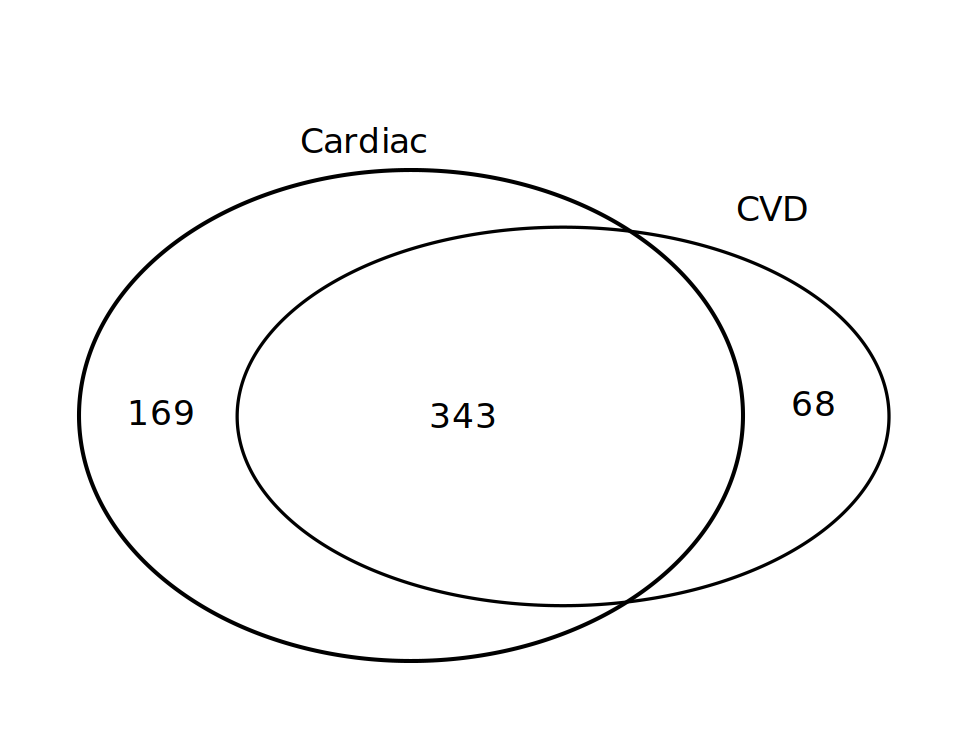

We choose as a target the union of the two pathologies

#### 1.2.3 Target

In [26]:
# target column will have:
#   1 if the patient died within 7 years of the first blood draw
#   0 otherwise
# since missing values in 'Date of death' column are considered as person that are still alive, they will have 0 in the target column
# 'target' = "is dead before 7 years by cardiac cause"
df['target']= (((df['Dataofdeath']-df['Dataprelievo'])/365 <= 7) & (df['Cardiaccauseofdeath'].dropna().astype(int) | df['CVDDeath'] ))
df['target'] = df['target'].astype(int)
df['target'].value_counts()

0    5240
1     580
Name: target, dtype: int64

In [27]:
# check if we have nan on the target feature
df['target'].isnull().any()

False

#### 1.2.4 Matching CABG , Cabg

In [28]:
pd.set_option('display.max_rows', 1000)
print(len(df[df['Cabg']==1]))
df[df['Cabg']==1][['Cabg','CABG']].isna().value_counts()
#with this command we see that we do not have missing dates for the CABG test

635


Cabg   CABG 
False  False    635
dtype: int64

#### 1.2.5 Matching PCI , Pci

In [29]:
print(len(df[df['Pci']==1]))
df[df['Pci']==1][['Pci','PCI']]['PCI'].isna().value_counts()
#with this command we see that we do not have missing dates for the CABG test

1013


False    1013
Name: PCI, dtype: int64

#### 1.2.5 Matching AMI , AMI followup

In [30]:
print(len(df[df['NonfatalAMI']==1]))
df[df['NonfatalAMI']==1][['NonFatalAMIFollowUp','NonfatalAMI']]['NonFatalAMIFollowUp'].isna().value_counts()

204


False    204
Name: NonFatalAMIFollowUp, dtype: int64

#### 1.2.6 Plot some statistichs

In [32]:
# how many male and female are in the dataset
df['GenderMale1'].value_counts()

1    4050
0    1770
Name: GenderMale1, dtype: int64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

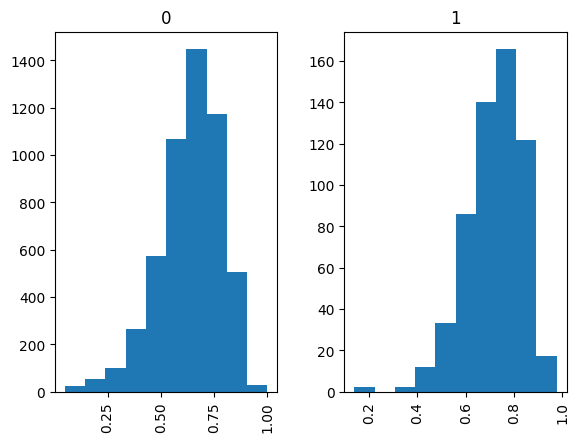

In [33]:
# histogram of the age of the patients in the dataset differentiating who has a cardiac cause of death and who has not
df['Age'].hist(by=df['target'])

In [ ]:
# altri plot?

#### 1.2.7 Filling missing values

In [34]:
df['Dataprelievo'].isnull().any()

True

In [35]:
df.dropna(subset='Dataprelievo',inplace=True) # there is one row that does not have a proper date, so it is removed

In [36]:
df = df.fillna(-1) # Finally we fill the missing values using -1

In [37]:
df.isna().values.any()

False

### 1.3 Correlation with target

In [41]:
df.corrwith(df["target"]).sort_values(ascending=False)

target                                    1.000000
Cardiaccauseofdeath                       0.923056
CVDDeath                                  0.828539
Totalmortality                            0.572824
Dataofdeath                               0.551693
FatalMIorSuddendeath                      0.519792
Causeofdeath                              0.460152
Collectedby                               0.439808
WmsiBas                                   0.208631
Diuretics                                 0.176195
Age                                       0.167489
vsx                                       0.159026
PostischemicDilated_Cardiomyopathy        0.158064
EPA                                       0.131970
Previous_MyocardialInfarction             0.118406
PMI                                       0.114497
LowT3                                     0.110436
PreviousCABG                              0.104834
Amiodarone                                0.097920
Valvulopatie                   

Since some features of the dataset such as CollectedBy or Cardiacofdeath are directly related to the target we define a list of features that will be used for classification.

What we remove:

Cabg, NonfatalAMI, Pci, Collectedby, Ictus, CABG, PCI


In [69]:
inputs_cols = [ 'HR', 'Weight', 'LDL', 'BMI', 'fT4', 'WmsiBas', 'NonFatalAMIFollowUp',
                        'Age', 'DimSettoIV', 'vsx', 'Dataprelievo',
                        'FollowUpData', 'HDL', 'Glycemia',
                        'Diastolicbloodpressure', 'fe', 'PatologiaTIROIDE',
                        'Systolicbloodpressure', 'Triglycerides', 'fT3', 'TSH',
                        'Totalcholesterol', 'Height', 'GenderMale1', 'Angina',
                        'PreviousCABG', 'PreviousPCI', 'Previous_MyocardialInfarction',
                        'Acute_MyocardialInfarction', #should we delete this?
                        'Angiography', 'Vessels', 'CAD',
                        'Smoke_Historyofsmoke', 'Diabetes_Historyofdiabetes',
                        'Hypertension_Historyofhypertension',
                        'Dyslipidemia_Hystoryofdyslipidemia', 'FamilyhistoryofCAD',
                        'Obesity_Historyofobesity', 'Documentedresting_orexertionalischemia',
                        'PostischemicDilated_Cardiomyopathy', 'PrimaryDilated_Cardiomyopathy',
                        'AtrialFibrillation', 'Paroxysmalatrialfibrillation', 'BBlockers',
                        'Amiodarone', 'Calciumchannelblockers', 'Diuretics', 'Antiplatelet',
                        'Nitrates', 'ACEinhibitors', 'Ipolipemizzanti', 'Antidiabetici',
                        'Euthyroid', 'SubclinicalprimaryhypothyroidismSCH',
                        'Subclinicalprimaryhyperthyroidism_SCT', 'LowT3', 'Ipotiroidismo',
                        'Ipertiroidismo', 'Controllo', 'Normal', 'SindromeX', 'AMI', 'PMI',
                        'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite',
                        'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione',
                        'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'DimParPost',
        ]

### 1.4 PyTorch data

In [43]:
import torch
from torch.utils.data import Dataset,WeightedRandomSampler,BatchSampler,DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 1.4.1 Splits

In [44]:
np.random.seed(seed)
label = df["target"]
train, test = train_test_split(df, test_size=0.2,random_state=seed, stratify=label)


In [45]:
train["target"].value_counts()

0    4191
1     464
Name: target, dtype: int64

In [46]:
test["target"].value_counts()

0    1048
1     116
Name: target, dtype: int64

#### 1.4.2 Augmentation

In [47]:
def info(dataset):
  print("Dataset shape: {}".format(dataset.shape))
  print("Number of missing values: {}".format(dataset.isin([-1]).sum().sum()))
  print("Mean of missing values per patient: {}".format(dataset.isin([-1]).sum(axis=1).mean()))
  print("Number of missing values in the target: {}".format(dataset.target.isin([-1]).sum()))

In [59]:
def aug1(x, p2, p1= 0.1):
  
  """
    aug1 function: create an augmented dataset with random missing values.
    
    param x: dataset
    param p1: fraction of sampled records to mask with missing values, default 10%
    param p2: uniform distribution probability
    return: augmented dataset

  """
  # randomly sampling p1% of records of original dataset
  x_sample= x.sample(frac=p1, replace=True, weights=None, random_state=1, axis=0, ignore_index=False)
  # do not randomize the target
  y = x_sample.pop('target')
  # randomize p2% of values of the sample dataset
  mask = np.random.choice([True, False], size=x_sample.shape, p=[p2,1-p2])
  x_sample.mask(mask, other= -1, inplace=True)
  # readding the target
  x_sample['target']= y

  # join the two datasets
  frames = [x, x_sample]
  aug_x = pd.concat(frames, ignore_index=True)

  #aug_x = x.append(x_sample, ignore_index=True)
  return aug_x

In [60]:
aug_train= aug1(train, p1=0.5, p2=0.05)

In [61]:
info(train)

Dataset shape: (4655, 94)
Number of missing values: 33944
Mean of missing values per patient: 7.2919441460794845
Number of missing values in the target: 0


In [62]:
info(aug_train)

Dataset shape: (6983, 94)
Number of missing values: 60757
Mean of missing values per patient: 8.700701704138622
Number of missing values in the target: 0


In [63]:
train["target"].value_counts()

0    4191
1     464
Name: target, dtype: int64

In [64]:
aug_train["target"].value_counts()

0    6287
1     696
Name: target, dtype: int64

#### 1.4.2 Datasets

In [70]:
class CardiacDataset(Dataset):
    def __init__(self,df,inputs,transforms=[]):
        self.df = df
        self.inputs = inputs
        self.target = 'target'
        self.transforms=transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      """output format: out[0]=target,out[1:]=input"""
      input = torch.tensor(self.df.iloc[idx][self.inputs].values)
      target = torch.tensor(self.df.iloc[idx][self.target])
      if self.transforms:
        for f in self.transforms:
          input,target=f(input,target)
      return input,target.view([1])

In [72]:
class samplingLoader(DataLoader):
    def __init__(self, ds, bs):
      self.ds = ds
      # Call the constructor of the parent class
      super().__init__(
                        self.ds,
                        sampler=self.ws(),
                        batch_size=bs,
                      )

    def ws(self):
      w = 1/self.ds.df.target.value_counts()
      weights = [w[int(c)] for c in self.ds.df.target]
      weighted_sampler = WeightedRandomSampler(
            weights = weights,
            num_samples = len(weights),
            replacement=True
      )
      return weighted_sampler

    def show(self):
      ok=[]
      nok=[]
      for IN,T in self:
        ok.append((T==0).sum())
        nok.append((T==1).sum())

      plt.bar(range(len(self)), ok, label='0', bottom=0)
      plt.bar(range(len(self)), nok, label='1', bottom=ok)
      plt.legend()
      plt.show()
      print(f"Unsampled rateo: {self.ds.df.target.mean():.2f} \n Sampled rateo:  {sum(ok)/sum(nok):.2f}")

In [ ]:
trainset = CardiacDataset(aug_train,inputs_cols)

#trainloader is balanced by weighted sampling
trainloader = samplingLoader(trainset,bs=32)
trainloader.show()
#validation and test are unbalanced and have all data in a single batch

## Utils

In [139]:
def compute_predictions(model, dataloader, return_probs=False):
  y_pred = []
  y_true = []
   
  for input, target in dataloader:
    pred = model(input).detach()
    
    if return_probs == False:
      pred = torch.argmax(pred, dim=1)
    
    y_pred.extend(pred.numpy())
    y_true.extend(target.numpy())

  if return_probs == False:
    return y_true, y_pred
  else:
    return torch.as_tensor(y_true), torch.as_tensor(y_pred)

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  classification_report, precision_score, recall_score, f1_score

# confusion matrix
def compute_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  ConfusionMatrixDisplay(cm).plot()


In [76]:
# F1 score, precion, recall
def compute_metrics(y_true, y_pred, print_summary=False):
  report = classification_report(y_true, y_pred, 
                      target_names=["0", "1"], output_dict=True)
  
  f1_0 =  report['0']['f1-score'] 
  f1_1 = report['1']['f1-score']    
  f1_weighted = report['weighted avg']['f1-score']
  if print_summary:
    print(classification_report(y_true, y_pred, 
                      target_names=["0", "1"]))
    
  return f1_0, f1_1, f1_weighted

In [142]:
from torchmetrics.classification import BinaryAUROC

def compute_auroc(model, dataloader):
  y_true, y_pred = compute_predictions(model, dataloader, return_probs=True)
  metric = BinaryAUROC(thresholds=None)
  print(y_pred.shape)
  print(y_true.shape)
  print(metric(y_pred, y_true))

In [77]:
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Accuracy
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

## 2. Simple Classifier

In [78]:
from torchvision import models
from torchsummary import summary

#add batch normalization, dropout
def classifier_architecture(dim_input, n_hiddens, dropout=0.1, print_model=True):
  modules = []
  dim_out_first_linear = dim_input*2
  for i in range(n_hiddens):
    modules.append(nn.Linear(dim_input, dim_out_first_linear))
    modules.append(nn.ReLU())
    dim_input = dim_out_first_linear
    dim_out_first_linear = dim_out_first_linear // 2
  
  # last layer for classification
  modules.append(nn.Dropout(p=dropout))
  modules.append(nn.Linear(dim_input, 2)) # two nodes in output, one for each class
  modules.append(nn.LogSoftmax(1))

  sequential = nn.Sequential(*modules)

  if print_model:
    print(sequential)

  return sequential

In [97]:
class Classifier(L.LightningModule):
    def __init__(self, architecture, loss_f=nn.NLLLoss(), lr=1e-3):
        super().__init__()
        self.classifier = architecture
        self.loss_f = loss_f
        self.lr = lr
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.classifier(x.float())
        loss = self.loss_f(out, y.flatten().long())
        self.log("train_loss", loss)
        acc = self.train_acc(torch.argmax(out,1), y.flatten())
        self.log('train_accuracy', acc, on_epoch=True)
        return loss

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        prediction = self.classifier(x.float())
        return prediction

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.classifier(x.float())
        loss = self.loss_f(out, y.flatten().long())
        self.log("val_loss", loss)
        acc = self.train_acc(torch.argmax(out,1), y.flatten())
        self.log('val_accuracy', acc, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.classifier(x.float())
        loss = self.loss_f(out, y.flatten().long())
        self.log("test_loss", loss)
        acc = self.train_acc(torch.argmax(out,1), y.flatten())
        self.log('test_accuracy', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [98]:
from lightning.pytorch.callbacks import Callback
import copy

class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        each_me = copy.deepcopy(trainer.callback_metrics)
        self.metrics.append(each_me)

In [161]:
from sklearn.model_selection import StratifiedKFold
import itertools as it
import logging

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

# configure logging on module level, redirect to file
logger = logging.getLogger("lightning.pytorch.core")
logger.addHandler(logging.FileHandler("core.log"))

def classifier_model_selection(data_df, inputs_cols, epochs, param_grid, k, encoder=None, 
                               transformers=False, categorical_inputs=None, df_transforms=None):
  """
    Computes a grid search for classifiers models.
    
    data_df (pandas df): original dataset
    inputs_cols (list): list of selected features for classification
    epochs (int): number of epochs to train the model
    param_grid (dict): dictionary key: hyperparameter value: [list of values]
    k (int): number of folds for k-fold cross validation
    encoder: if is not None data is encoded using the autoencoder

    transformers=False, categorical_inputs=None, df_transforms=None
    
    return: 
      results_df (pandas df): a Dataframe containing the results of the model selection 
      trainloader (Dataloader): computed dataloader on training set
      valloader (Dataloader): computed dataloader on validation set
  """

  

  keys = param_grid.keys()
  combinations = it.product(*(param_grid[key] for key in keys))
  param_list = list(combinations)

  keys_list = list(keys)
  results_cols = keys_list + ["train_loss", "val_loss", "train_accuracy", "val_accuracy", "f1_0", "f1_1", "f1_weighted"]
  results_df = pd.DataFrame(columns=results_cols)

  input_train_df = data_df[inputs_cols]
  target_train_df = data_df["target"]

  skf = StratifiedKFold(n_splits=k)

  for i, elem in enumerate(param_list):
    if transformers:
      nhead = elem[0]
    
    else:
      layers = elem[0]
      dropout = elem[1]

    val_loss_list = []
    tr_loss_list = []
    val_acc_list = []
    tr_acc_list = []
    f1_0_list = []
    f1_1_list = []
    f1_weighted_list = []

    for j, (train_index, test_index) in enumerate(skf.split(input_train_df, target_train_df)):
      print(f"hyperpatameters combination: \t{i}/{len(param_list)} \tfold:\t{j+1}/{k}")
      X_train_split, X_val_split = data_df.iloc[train_index, :], data_df.iloc[test_index, :]
      
      
      if transformers:
        trainset = CardiacTokens(X_train_split,inputs_cols,categorical_inputs,df_transforms=df_transforms)
        valset = CardiacTokens(X_val_split,inputs_cols,categorical_inputs,df_transforms=[tokenize])
      else:
        aug = aug1(X_train_split, p1=0.5, p2=0.05)
        trainset,valset = [CardiacDataset(e,inputs_cols) for e in [aug,X_val_split]]
     
      if encoder is not None:
        trainset.transforms=[Encode(encoder)]
        valset.transforms=[Encode(encoder)]
        
      dim_input = len(trainset[0][0])
      
      #trainloader is balanced by weighted sampling
      trainloader = samplingLoader(trainset,bs=32)

      #validation is unbalanced and have all data in a single batch
      valloader = DataLoader(valset,batch_size=len(valset))

      if transformers:
        model = TransClassifier(nhead=nhead)

      else:
        architecture = classifier_architecture(dim_input, layers, dropout, print_model=False)
        model = Classifier(architecture)

      trainer = L.Trainer(max_epochs = epochs,
                    callbacks=[
                        EarlyStopping(monitor="val_loss", mode="min", patience=6),
                        EarlyStopping(monitor="val_accuracy", mode="max", patience=6),
                        MetricsCallback()
                        ], 
                    enable_progress_bar=False,
                    )
      
      trainer.fit(model, trainloader, valloader)

      # access callback metrics to get loss and accuracy
      # format of callback metrics
      """
        {'train_loss': tensor(0.3704),
        'train_accuracy': tensor(0.5007),
        'train_accuracy_step': tensor(0.6296),
        'val_loss': tensor(0.0995),
        'val_accuracy': tensor(0.9005),
        'train_accuracy_epoch': tensor(0.5007)}
      """

      train_loss = round(trainer.callback_metrics["train_loss"].item(), 4)
      train_accuracy = round(trainer.callback_metrics["train_accuracy"].item(), 4)
      val_loss = round(trainer.callback_metrics["val_loss"].item(), 4)
      val_accuracy = round(trainer.callback_metrics["val_accuracy"].item(), 4)

      # compute f1 scores on validation set
      y_true, y_pred = compute_predictions(model, valloader)
      f1_0, f1_1, f1_weighted = compute_metrics(y_true, y_pred)

      # append loss, accuracy, f1 score
      val_loss_list.append(val_loss)
      tr_loss_list.append(train_loss)
      val_acc_list.append(val_accuracy)
      tr_acc_list.append(train_accuracy)
      f1_0_list.append(f1_0)
      f1_1_list.append(f1_1)
      f1_weighted_list.append(f1_weighted)

    # out of k-fold for cycle, compute mean of the arrays and append to pandas result df
    # add also std?
    mean_val_loss = np.mean(np.array(val_loss_list))
    mean_train_loss = np.mean(np.array(tr_loss_list))
    mean_val_acc = np.mean(np.array(val_acc_list))
    mean_train_acc = np.mean(np.array(tr_acc_list))
    mean_f1_0 = np.mean(np.array(f1_0_list))
    mean_f1_1 = np.mean(np.array(f1_1_list))
    mean_f1_weighted = np.mean(np.array(f1_weighted_list))

    if transformers:
      new_row = [nhead, mean_train_loss, mean_val_loss, mean_train_acc, mean_val_acc, mean_f1_0, mean_f1_1, mean_f1_weighted]
    else:
      new_row = [layers, dropout, mean_train_loss, mean_val_loss, mean_train_acc, mean_val_acc, mean_f1_0, mean_f1_1, mean_f1_weighted]
    results_df.loc[len(results_df)] = new_row
  
  return results_df, trainloader, valloader

In [100]:
len(aug_train)//6

1163

In [101]:
len(test)

1164

In [105]:
epochs = 30
kfold_splits = 6 # try to set kfold_splits such that len(valset) = len(testset)

# params grid for classifiers, if more hyperparameters are added change also classifier_architecture() method
# TODO add elements on the list of possible values in the dictionary
param_grid = {
        'layers': [3, 4],
        "dropout": [0.2]
}

results_df, trainloader, valloader = classifier_model_selection(data_df=aug_train, inputs_cols=inputs_cols, epochs=epochs, param_grid=param_grid, k=kfold_splits)

hyperpatameters combination: 	0/2 	fold:	06
hyperpatameters combination: 	0/2 	fold:	16
hyperpatameters combination: 	0/2 	fold:	26
hyperpatameters combination: 	0/2 	fold:	36
hyperpatameters combination: 	0/2 	fold:	46
hyperpatameters combination: 	0/2 	fold:	56
hyperpatameters combination: 	1/2 	fold:	06
hyperpatameters combination: 	1/2 	fold:	16
hyperpatameters combination: 	1/2 	fold:	26
hyperpatameters combination: 	1/2 	fold:	36
hyperpatameters combination: 	1/2 	fold:	46
hyperpatameters combination: 	1/2 	fold:	56


In [106]:
results_df

,layers,dropout,train_loss,val_loss,train_accuracy,val_accuracy,f1_0,f1_1,f1_weighted
0,3.0,0.2,0.048233,0.485067,0.975383,0.877417,0.930244,0.487215,0.886087
1,4.0,0.2,0.030317,0.432533,0.968383,0.881133,0.933866,0.493510,0.889975


In [107]:
# get best hyperparameters according to f1 weighted
results_df = results_df.sort_values(by=['f1_weighted'], ascending=False)
layers = int(results_df.iloc[0]["layers"])
dropout = results_df.iloc[0]["dropout"]

# refit the model
dim_input = len(trainset[0][0])
architecture = classifier_architecture(dim_input, layers, dropout, print_model=True)
cm1 = Classifier(architecture)

trainer = L.Trainer(max_epochs = epochs,
                      logger=TensorBoardLogger(save_dir="lightning_logs/", name="Simple classifier"),
                      callbacks=[
                          EarlyStopping(monitor="val_loss", mode="min", patience=6),
                          EarlyStopping(monitor="val_accuracy", mode="max", patience=6),
                          MetricsCallback()
                          ]
                      )
        
trainer.fit(cm1, trainloader, valloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [109]:
testset = CardiacDataset(test,inputs_cols)
testloader = DataLoader(testset,batch_size=len(testset))
trainer.test(cm1, testloader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8393470644950867     │
│         test_loss         │    0.5494820475578308     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5494820475578308, 'test_accuracy': 0.8393470644950867}]

In [110]:
y_true, y_pred = compute_predictions(cm1, testloader)

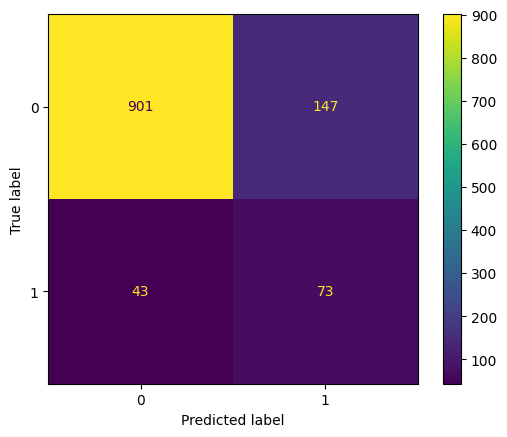

In [111]:
compute_cm(y_true, y_pred)

In [114]:
compute_metrics(y_true, y_pred, print_summary=True)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1048
           1       0.33      0.63      0.43       116

    accuracy                           0.84      1164
   macro avg       0.64      0.74      0.67      1164
weighted avg       0.89      0.84      0.86      1164



(0.9046184738955824, 0.43452380952380953, 0.8577705520166085)

## 3. Autoencoder-Classifier

### 3.1 Autoencoder

In [115]:
l = len(trainset[0][0])
encoder = nn.Sequential(nn.Linear(  l   , 4*l//5), nn.ReLU(),
                        nn.Linear(4*l//5, 3*l//5), nn.ReLU(),
                        nn.Linear(3*l//5, 2*l//5), nn.ReLU(),
                        nn.Linear(2*l//5, 1*l//5),
                        )
decoder = nn.Sequential(nn.Linear(1*l//5, 2*l//5), nn.ReLU(),
                        nn.Linear(2*l//5, 3*l//5), nn.ReLU(),
                        nn.Linear(3*l//5, 4*l//5), nn.ReLU(),
                        nn.Linear(4*l//5,   l),
                        )

class AutoCardioCoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder

    def training_step(self, batch, batch_idx):
        x, y = batch[0].float(), batch[1].float()
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch[0].float(), batch[1].float()
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch[0].float(), batch[1].float()
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

ae1 = AutoCardioCoder(encoder, decoder)

In [116]:
trainer = L.Trainer(max_epochs = 30,
                    #val_check_interval=1,
                    #max_time="00:00:00:00",
                    #enable_checkpointing=True,
                    logger=TensorBoardLogger(save_dir="lightning_logs/", name="Auto Cardio Coder")
                    )

trainer.fit(ae1, trainloader, valloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### 3.2 Classifier

In [118]:
#we can compute encoded inputs like this:
ae1.encoder(trainset[0][0].float()).shape

torch.Size([15])

In [119]:
class Encode(object):
    """Encode the input"""

    def __init__(self, encoder):
        self.encoder = encoder

    def __call__(self, x,y):
        return self.encoder(x.float()), y

In [121]:
epochs = 30
kfold_splits = 6 # try to set kfold_splits such that len(valset) = len(testset)

# params grid for classifiers, if more hyperparameters are added change also classifier_architecture() method
# TODO add elements on the list of possible values in the dictionary
param_grid = {
        'layers': [3, 4],
        "dropout": [0.2]
}

results_df, trainloader, valloader = classifier_model_selection(data_df=aug_train, inputs_cols=inputs_cols, epochs=epochs, param_grid=param_grid, k=kfold_splits, encoder=ae1.encoder)

hyperpatameters combination: 	0/2 	fold:	1/6
hyperpatameters combination: 	0/2 	fold:	2/6
hyperpatameters combination: 	0/2 	fold:	3/6
hyperpatameters combination: 	0/2 	fold:	4/6
hyperpatameters combination: 	0/2 	fold:	5/6
hyperpatameters combination: 	0/2 	fold:	6/6
hyperpatameters combination: 	1/2 	fold:	1/6
hyperpatameters combination: 	1/2 	fold:	2/6
hyperpatameters combination: 	1/2 	fold:	3/6
hyperpatameters combination: 	1/2 	fold:	4/6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hyperpatameters combination: 	1/2 	fold:	5/6
hyperpatameters combination: 	1/2 	fold:	6/6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
results_df

,layers,dropout,train_loss,val_loss,train_accuracy,val_accuracy,f1_0,f1_1,f1_weighted
0,3.0,0.2,0.607283,0.584750,0.72255,0.69555,0.801982,0.305457,0.752493
1,4.0,0.2,0.599467,0.625467,0.63210,0.61885,0.662690,0.223018,0.618861


In [125]:
# get best hyperparameters according to f1 weighted
results_df = results_df.sort_values(by=['f1_weighted'], ascending=False)
layers = int(results_df.iloc[0]["layers"])
dropout = results_df.iloc[0]["dropout"]


# refit the model
dim_input = len(next(iter(trainloader))[0][0]) # in questo modo rimuovo un batch dal trainloader?
architecture = classifier_architecture(dim_input, layers, dropout, print_model=True)

Sequential(
  (0): Linear(in_features=15, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=15, bias=True)
  (3): ReLU()
  (4): Linear(in_features=15, out_features=7, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=7, out_features=2, bias=True)
  (8): LogSoftmax(dim=1)
)


In [ ]:
cm2 = Classifier(architecture)

trainer = L.Trainer(max_epochs = epochs,
                      logger=TensorBoardLogger(save_dir="lightning_logs/", name="Encoder classifier"),
                      callbacks=[
                          EarlyStopping(monitor="val_loss", mode="min", patience=6),
                          EarlyStopping(monitor="val_accuracy", mode="max", patience=6),
                          MetricsCallback()
                          ]
                      )
        
trainer.fit(cm2, trainloader, valloader)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [127]:
testset.transforms=[Encode(ae1.encoder)]
trainer.test(cm2, testloader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6752577424049377     │
│         test_loss         │    0.5916279554367065     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5916279554367065, 'test_accuracy': 0.6752577424049377}]

In [128]:
y_true, y_pred = compute_predictions(cm2, testloader)

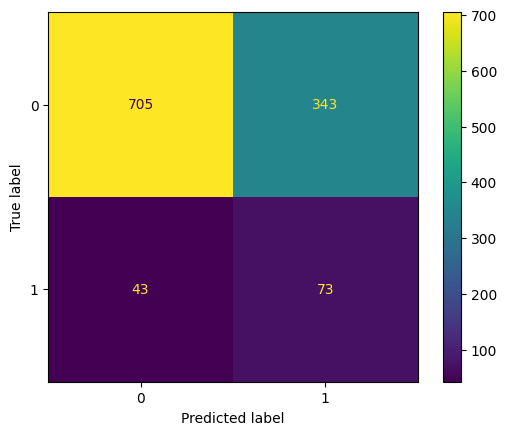

In [129]:
compute_cm(y_true, y_pred)

In [131]:
compute_metrics(y_true, y_pred, print_summary=True)

              precision    recall  f1-score   support

           0       0.94      0.67      0.79      1048
           1       0.18      0.63      0.27       116

    accuracy                           0.67      1164
   macro avg       0.56      0.65      0.53      1164
weighted avg       0.87      0.67      0.73      1164



(0.7850779510022272, 0.27443609022556387, 0.7341892432272333)

In [ ]:
# compute_auroc(cm2, testloader)

## 4. Transformer encoder

###  4.1 Tokenization
with this process we condense all the columns as words of a single dictionary

In [144]:
categorical_inputs = categoricals.intersection(inputs_cols)

In [145]:
word_dict={}

increment = 0
for key in categorical_inputs:
  if key in num_encodings.keys():
    # if we have a dict use that
    vals = num_encodings[key]
    word_dict[key] = {num:num+increment for name,num in vals.items()}
    increment=1+max(word_dict[key].values())
    word_dict[key][-1]=increment
    increment+=1
  else:
    # otherwise assume binary
    word_dict[key] = {}
    word_dict[key][-1] = increment
    increment+=1
    word_dict[key][0] = increment
    increment+=1
    word_dict[key][1] = increment
    increment+=1

In [ ]:
word_dict

In [147]:
inverted_word_dict = {key:{v:k for k,v in dct.items()} for key,dct in word_dict.items()}

In [148]:
def tokenize(df):
  df_tokens = pd.DataFrame(columns=df.keys())
  for key in df.keys():
    if key in categorical_inputs:
      df_tokens[key] = df[key].apply(word_dict[key].get)
    else:
      df_tokens[key] = df[key]
  return df_tokens

### 4.2 Tokenized Pytroch

In [149]:
class CardiacTokens(Dataset):
    def __init__(self,df,inputs,categoricals,df_transforms=[],transforms=[]):
        if df_transforms:
          for t in df_transforms:
            self.df = t(df)
        else:
          self.df = df
        self.categoricals = categoricals
        self.inputs = inputs

        self.cat_in = list( set(self.categoricals).intersection(set(self.inputs)))
        self.non_cat_in = list(set(self.inputs) - set(self.categoricals))
        self.target = 'target'
        self.transforms=transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      """output format: out[0]=target,out[1:]=input"""
      cat = torch.tensor(self.df.iloc[idx][self.cat_in].values)
      noncat = torch.tensor(self.df.iloc[idx][self.non_cat_in].values)
      input = [cat,noncat]
      target = torch.tensor(self.df.iloc[idx][self.target])

      #if self.transforms:
      #  for f in self.transforms:
      #    input,target=f(input,target)
      return input,target.view([1])

In [150]:
df_transforms = [lambda df:aug1(df,p1=0.5, p2=0.05), tokenize]

In [ ]:
#[cat,noncat],target =next(iter(trainloader_t))

### 4.3 Transformer Encoder

In [155]:
num_unique_words = increment
num_categorical = len(categorical_inputs)
num_non_categorical = len(inputs_cols) - num_categorical


class TransClassifier(L.LightningModule):
    def __init__(self, in_emb=num_unique_words, dim_emb=500,num_categorical=num_categorical, num_non_categorical=num_non_categorical, nhead=8, dim_feedforward=1024):
        super().__init__()
        self.dim_emb=dim_emb
        self.num_non_categorical=num_non_categorical
        self.loss = torch.nn.NLLLoss()
        #torch.nn.CrossEntropyLoss() includes softmax!
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.embedding = nn.Embedding(in_emb+1, dim_emb)
        self.linear = nn.Sequential(nn.Linear(num_non_categorical, num_non_categorical*dim_emb),nn.ReLU())
        self.enc_layer = nn.TransformerEncoderLayer(dim_emb,nhead=nhead,dim_feedforward=dim_feedforward)
        self.encoder = nn.TransformerEncoder(
            self.enc_layer,
            num_layers = 1
        )
        self.classifier = nn.Sequential(
            nn.Linear((num_categorical+num_non_categorical)*dim_emb,2),
            #nn.ReLU(),
            nn.LogSoftmax(1),
            )

    def model(self,cat,noncat):
        word_vec = self.embedding(cat.int())
        dense_vec=self.linear(noncat.float()).view(-1,self.num_non_categorical,self.dim_emb)
        # concatenate inputs
        enc_in = torch.concat([word_vec,dense_vec],dim=1)
        #apply encoder and flatten the last two dimensions
        code = self.encoder(enc_in).flatten(start_dim=1)
        #compute classifier
        return self.classifier(code)


    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        prediction = self.model(*x)
        return prediction


    def training_step(self, batch, batch_idx):
        x,t = batch
        y = self.model(*x)
        loss = self.loss(y, t.flatten().long())
        acc = self.train_acc(torch.argmax(y,1), t.flatten())
        self.log("train_loss", loss)
        self.log('train_accuracy', acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x,t = batch
        y = self.model(*x)
        loss = self.loss(y, t.flatten().long())
        acc = self.val_acc(torch.argmax(y,1), t.flatten())
        self.log("val_loss", loss)
        self.log('val_accuracy', acc, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x,t = batch
        y = self.model(*x)
        loss = self.loss(y, t.flatten().long())
        acc = self.test_acc(torch.argmax(y,1), t.flatten())
        self.log("test_loss", loss)
        self.log('test_accuracy', acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
epochs = 30
kfold_splits = 6 # try to set kfold_splits such that len(valset) = len(testset)

# params grid for classifiers, if more hyperparameters are added change also classifier_architecture() method
# TODO add elements on the list of possible values in the dictionary
param_grid = {
        'nhead': [1,2]
}

results_df, trainloader, valloader = classifier_model_selection(data_df=aug_train, inputs_cols=inputs_cols, epochs=epochs, param_grid=param_grid, k=kfold_splits,
                                                                transformers=True, categorical_inputs=categorical_inputs, df_transforms=df_transforms)


hyperpatameters combination: 	0/2 	fold:	1/6
hyperpatameters combination: 	0/2 	fold:	2/6
hyperpatameters combination: 	0/2 	fold:	3/6
hyperpatameters combination: 	0/2 	fold:	4/6
hyperpatameters combination: 	0/2 	fold:	5/6
hyperpatameters combination: 	0/2 	fold:	6/6
hyperpatameters combination: 	1/2 	fold:	1/6
hyperpatameters combination: 	1/2 	fold:	2/6
hyperpatameters combination: 	1/2 	fold:	3/6
hyperpatameters combination: 	1/2 	fold:	4/6
hyperpatameters combination: 	1/2 	fold:	5/6
hyperpatameters combination: 	1/2 	fold:	6/6


In [1]:
results_df

NameError: ignored

In [ ]:
# get best hyperparameters according to f1 weighted
results_df = results_df.sort_values(by=['f1_weighted'], ascending=False)
nhead = int(results_df.iloc[0]["nhead"])

In [ ]:
tec1 = TransClassifier(nhead=nhead)
trainer = L.Trainer(max_epochs = 30,
                    #val_check_interval=1,
                    #max_time="00:00:00:00",
                    #enable_checkpointing=True,
                    logger=TensorBoardLogger(save_dir="lightning_logs/", name="Transformer Encoder 1"),
                    callbacks=[
                        EarlyStopping(monitor="val_loss", mode="min", patience=6),
                        EarlyStopping(monitor="val_accuracy", mode="max", patience=6)
                        ],
                    )
trainer.fit(tec1, trainloader, valloader)

In [ ]:
import seaborn as sns
from bertviz import head_view, model_view

In [ ]:
def plot_attention_score_matrix(tec1,testloader_t,idx):
    #NOTE: THIS FUNCTION AS THE MODEL ITSELF IS DEVELOPED FOR 1 LAYER and 1 HEAD ONLY.
    # generate test data
    data_in,target = next(iter(testloader_t))
    word = tec1.embedding(data_in[0][idx].int())
    dense = tec1.linear(data_in[1][idx].float()).view(tec1.num_non_categorical,tec1.dim_emb)
    embedded = torch.concat([word,dense], dim=0)

    print(data_in[0][idx].shape, data_in[1][idx].shape)
    print(embedded.shape)

    # get attention matrices from the trained model
    in_proj_weight = tec1.enc_layer.self_attn.state_dict()['in_proj_weight']
    Q, K, V = torch.split(in_proj_weight, [tec1.dim_emb, tec1.dim_emb, tec1.dim_emb])

    #this is the attention declaration in pytorch:
    #attn_weight = torch.softmax((Q @ K.transpose(-2, -1) / np.sqrt(Q.size(-1))), dim=-1)

    # map the embedded vectors with the attention matrices
    querys = [ Q@emb_word for emb_word in embedded]
    keys = [ K@emb_word for emb_word in embedded]

    # compute dot product distances
    scores = torch.zeros([len(querys),len(keys)])
    for i,q in enumerate(querys):
      for j,k in enumerate(keys):
        scores[i,j] = torch.dot(q,k)


    # normalize dot product distances
    weight = torch.nn.functional.softmax(scores)

    # compute ordered column labels
    col_labels = trainloader_t.dataset.cat_in
    col_labels.extend(trainloader_t.dataset.non_cat_in)


    # compute values (invert tokenization) ## TODO: invert normalization
    sequence = [inverted_word_dict[key][int(val)] for key,val in zip(trainloader_t.dataset.cat_in,data_in[0][idx].tolist())]
    sequence.extend(data_in[1][idx].tolist())

    # generate plot labels
    labels = [f"{label} = {value:.2f}" for label,value in zip(col_labels,sequence)]

    # plot
    sns.set(rc={'figure.figsize':(20,20)})
    g = sns.heatmap(weight.detach().numpy(), annot=False)
    g.set(title=f"Test patient {idx} in outcome class {int(target[0])}")
    g.set(xticklabels=labels,yticklabels=labels)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

    return weight , labels

In [ ]:
att,tok = plot_attention_score_matrix(tec1,testloader_t,2)

In [ ]:
head_view(
    [att.view(1,1,*att.shape)], # bertviz format torch.tensor:[1,num_heads,sentence_len]
                               # for each element in  list:[ layers ]
                               # 1 is a placeholder for the batch size, and MUST be 1
    tok, # bertviz format list:[sentence_len]
)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

KeyboardInterrupt: ignored

In [ ]:
testset_t = CardiacTokens(test,inputs_cols,categorical_inputs,df_transforms=[tokenize])
testloader_t = DataLoader(testset_t,batch_size=len(testset_t))

In [ ]:
trainer.test(tec1, testloader_t)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.811855673789978     │
│         test_loss         │    0.48728659749031067    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.48728659749031067, 'test_accuracy': 0.811855673789978}]

In [ ]:
y_true, y_pred = compute_predictions(tec1, testloader_t, transformers=True)

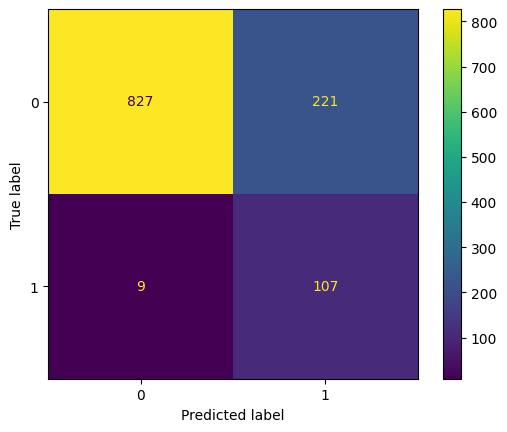

In [ ]:
compute_cm(y_true, y_pred)

In [ ]:
compute_metrics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1048
           1       0.33      0.92      0.48       116

    accuracy                           0.80      1164
   macro avg       0.66      0.86      0.68      1164
weighted avg       0.92      0.80      0.84      1164



Attention matrix https://lightning.ai/docs/pytorch/latest/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html

In [ ]:
#TODO
#x, labels = next(iter(testloader_t))
#attention_maps = tec1.get_attention_maps(x)
#attention_maps

## Comparison

In [ ]:
# At the moment we only have a FC autoencoder (not a Transformer based).
# With current settings the accurcay on the test are:
##########    0.86 for the simple classifer
##########    0.84 for the encoder classifer